https://github.com/iqiukp/SVDD-Python

https://github.com/achevrot/SVDD


<h1><b>
<div dir='rtl' align='Center'><font size='16' face='Calibri'>
پیاده سازی الگوریتم SVDD در پایتون
<br/>Support Vector Data Description
</font>
</div>
</b>
</h1>

<div dir='rtl' align='RIGHT'><font size='4' face='Calibri'>الگوریتم SVDD یک الگوریتم  توصیف داده است که از الگوریتم ماشین بردار پشتیبان الهام گرفته شده است، این الگوریتم یک مرز کروی شکل در اطراف یک مجموعه داده به دست می آورد و مشابه طبقه بندی کننده بردار پشتیبانی می تواند با استفاده از سایر توابع هسته انعطاف پذیر شود. این روش در برابر موارد پرت در مجموعه آموزشی مقاوم است[1].این الگوریتم می‌تواند برای مجموعه داده‌های هدف، یا برای هر کلاس از اشیاء در مجموعه داده‌های هدف، توضیحاتی ارائه دهد
</font></div>

1- David M.J. Tax & Robert P.W. Duin(2004). Support Vector Data Description

In [147]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets # to use IRIS dataset
from collections import defaultdict
import warnings
from cvxopt import matrix, solvers
from sklearn.metrics import accuracy_score
import sklearn.metrics.pairwise as smp
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.metrics import auc
from mpl_toolkits.mplot3d import Axes3D

<h1>Implementation of SVDD class</h1>

In [148]:
class SVDD():

  pPenalty = None
  nPenalty  = None
  #---------------- Model info -----------------
  support_vectors = None
  support_vectors_value = None 
  support_vector_index = None
  kernel_params = None
  R = None
  center = None
  alpha = None
  data = None
  iteration = None
  accuracy =None
  kernel_matrix = None
  distance = None
  #---------------------------------------------

  def __init__(self, positive_penalty:float=None, negetive_penalty:float=None, kernel:dict={"type": 'gauss', "sigma": 1/25}):
      """ 
        "positive penalty": positive penalty factor
        "negative penalty": negative penalty factor
        "kernel"          : kernel function parameters         
        "option"          : some options 
      """    
      self.pPenalty = positive_penalty
      self.nPenalty = negetive_penalty
      self.kernel_params = kernel
      #self.parameters = parameters

  def fit(self, data, label):
        
        # Labels are converted to int type for synchronizing calculations
        label = np.array(label, dtype = 'int')      
        
        # When the label of all data is 1, their sum is equal to the number of samples.
        # This point is used to detect whether the data is of one type of label or a combination of several types
        if np.abs(np.sum(label)) == data.shape[0]:
            self.labeltype = 'singleclass' # single class
        else:
            self.labeltype = 'multiclass' # multiclass
        
        # index of positive and negative samples
        pIndex = label[:,0] == 1
        nIndex = label[:,0] == -1
        
        # threshold for support vectors
        threshold = 1e-7
        
        # compute the kernel matrix
        K = self.getKernel(data, data)

        # solve the Lagrange dual problem
        alpha, obj, iteration = self.solve(K, label)
        
        # find the index of support vectors
        sv_index = np.where(alpha > threshold)[0][:]

        # support vectors and alf
        sv_value = data[sv_index, :]
        sv_alpha = alpha[sv_index]
        
        # compute the center of initial feature space
        center = np.dot(alpha.T, data)
        
        ''''
        compute the radius: eq(15)
        
        The distance from any support vector to the center of 
        the sphere is the hypersphere radius. 
        Here take the 1st support vector as an example.
        
        '''
        # the 1st term in eq(15)
        used = 0
        term_1 = K[sv_index[used], sv_index[used]]
        
        # the 2nd term in eq(15)
        term_2 = -2*np.dot(K[sv_index[used], :], alpha)
        
        # the 3rd term in eq(15)
        term_3 = np.dot(np.dot(alpha.T, K), alpha)

        # R
        radius = np.sqrt(term_1 + term_2 + term_3)
        
        # numbers of positive and negative samples
        pData = np.sum(pIndex)/data.shape[0]
        nData = np.sum(nIndex)/data.shape[0]
        
        # number of support vectors
        # nSVs = sv_index.shape[0]
        # radio of  support vectors
        # rSVs = sv_index.shape[0]/data.shape[0]
       
        # this term is stored to use in predict method
        self.term3 = term_3

        # Stores the model info
        self.nSupportVectors = sv_index.shape[0]
        # rate of  support vectors
        self.nSV_rate = sv_index.shape[0]/data.shape[0]
        self.support_vectors = sv_alpha
        self.support_vectors_value = sv_value 
        self.support_vector_index = sv_index
        self.kernel_matrix = K
        self.R = radius
        self.center = center
        self.alpha = alpha
        self.data = data
        self.iteration = iteration
  
  def predict(self, test_data, test_labels):
    
        """ 
        DESCRIPTION
        
        Test the testing data using the SVDD model
    
        distance = test(model, Y)
        
        --------------------------------------------------        
        INPUT
        data        Test data (n*d) 
                        n: number of samples
                        d: number of features
        label       Test label (n*1)
                        positive: 1
                        negative: -1
            
        OUTPUT
        distance    Distance between the test data and hypersphere
        --------------------------------------------------
        
        """    
        n = test_data.shape[0]
        
        # compute the kernel matrix
        K = self.getKernel(test_data, self.data)
        
        # the 1st term
        term_1 = self.getKernel(test_data, test_data)
        
        # the 2nd term
        tmp_1 = -2*np.dot(K, self.alpha)
        term_2 = np.tile(tmp_1, (1, n))
        
        # the 3rd term
        term_3 =  self.term3
        
        # distance
        distance = np.sqrt(np.diagonal(term_1+term_2+term_3))
        
        # predicted label
        predictedlabel = np.mat(np.ones(n)).T
        fault_index = np.where(distance > self.R)[1][:]
        predictedlabel[fault_index] = -1
            
        # compute prediction accuracy
        self.accuracy = np.sum(predictedlabel == test_labels)/n
        self.distance = distance

        return self.accuracy

#---------------------------------------------------------------------------------------------------------------------
  def solve(self, K, label):
        """ 
        DESCRIPTION
        
        Solve the Lagrange dual problem
        
        solve(self, K, label)
        
        --------------------------------------------------
        INPUT
        K         Kernel matrix
        label     training label
        
                        
        OUTPUT
        alf       Lagrange multipliers
        
        --------------------------------------------------
        
        minimize    (1/2)*x'*P*x + q'*x
        subject to  G*x <= h
                    A*x = b                    
        --------------------------------------------------
        
        """ 
        solvers.options['show_progress'] = False
        # Interpret dat input as a matrix
        label = np.mat(label)
        K = np.multiply(label*label.T, K)
        
        # P
        n = K.shape[0]
        P = K+K.T
        
        # q
        q = -np.multiply(label, np.mat(np.diagonal(K)).T)

        # G
        G1 = -np.eye(n)
        G2 = np.eye(n)
        G = np.append(G1, G2, axis=0)
        
        # h
        h1 = np.mat(np.zeros(n)).T # lb
        h2 = np.mat(np.ones(n)).T
        if self.labeltype == 'singleclass':
            h2[label == 1] = self.pPenalty
        
        if self.labeltype == 'multiclass':
            h2[label == 1] = self.pPenalty
            h2[label == -1] = self.nPenalty
            
        h = np.append(h1, h2, axis=0)
        
        # A, b
        A = np.mat(np.ones(n))
        b = 1.
        
        #
        P = matrix(P)
        q = matrix(q)
        G = matrix(G)
        h = matrix(h)
        A = matrix(A)
        b = matrix(b)
        
        sol =solvers.qp(P, q, G, h, A, b)
        alf = np.array(sol['x'])
        obj = np.array(sol['dual objective'])
        iteration = np.array(sol['iterations'])

        return alf, obj, iteration

  def getKernel(self, X, Y):
    
        """ 
        Compute kernel matrix 
        X         data (n*d)
        Y         data (m*d)

        OUTPUT
        K         kernel matrix 

        type   -  
        ------------------------------------
        linear :  k(x,y) = x'*y+c
        poly   :  k(x,y) = (x'*y+c)^d
        gauss  :  k(x,y) = exp(-s*||x-y||^2)
        tanh   :  k(x,y) = tanh(g*x'*y+c)
        lapl   :  k(x,y) = exp(-s*||x-y||)
           
        degree -  d
        offset -  c
        sigma  -  s
        gamma  -  g
        
        --------------------------------------------------      
        ker    - 
        
        ker = {"type": 'gauss', "width": s}
        ker = {"type": 'linear', "offset": c}
        ker = {"type": 'poly', "degree": d, "offset": c}
        ker = {"type": 'tanh', "gamma": g, "offset": c}
        ker = {"type": 'lapl', "width": s}
    
        """
        def gaussFunc():
            
            if self.kernel_params.__contains__("sigma"):
                s =  self.kernel_params["sigma"]
            else:
                s = 2
            K = smp.rbf_kernel(X, Y, gamma=s)

                
            return K
            
        def linearFunc():
            
            if self.kernel_params.__contains__("offset"):
                c =  self.kernel_params["offset"]
            else:
                c = 0

            K = smp.linear_kernel(X, Y)+c
            
            return K
        
        def ployFunc():
            if self.kernel_params.__contains__("degree"):
                d =  self.kernel_params["degree"]
            else:
                d = 2
                
            if self.kernel_params.__contains__("offset"):
                c =  self.kernel_params["offset"]
            else:
                c = 0
                
            K = smp.polynomial_kernel(X, Y, degree=d, gamma=None, coef0=c)
            
            return K
             
        def laplFunc():
            
            if self.kernel_params.__contains__("sigma"):
                s =  self.kernel_params["sigma"]
            else:
                s = 2
            K = smp.laplacian_kernel(X, Y, gamma=s)

            return K
    
        def tanhFunc():
            if self.kernel_params.__contains__("gamma"):
                g =  self.kernel_params["gamma"]
            else:
                g = 0.01
                
            if self.kernel_params.__contains__("offset"):
                c =  self.kernel_params["offset"]
            else:
                c = 1
            
            K = smp.sigmoid_kernel(X, Y, gamma=g, coef0=c)

            return K

        kernelType = self.kernel_params["type"]
        kernels = { "gauss"   : gaussFunc  ,        
                    "linear"  : linearFunc ,
                    "poly"    : ployFunc   ,
                    "lapl"    : laplFunc   ,
                    "tanh"    : tanhFunc   ,
                  }
        
        return kernels[kernelType]()

  def print_model(self):
    print('\n')
    print('--------- SVDD model results ---------\n')
    print('Kernel function              %s'      % self.kernel_params['type'])
    print('Raduis                       %.10f'    % self.R)
    print('Iteration                    %d'      % self.iteration)
    print('Number of Support vectors    %d'      % self.nSupportVectors)  # number of support vectors
    print('Rate  of  Support vectors    %.3f %%' % (100*self.nSV_rate))   # Rate   of support vectors
    print('accuracy                     %.3f%%'  % (100*self.accuracy))
    print("")
    


**Visualization**

In [179]:
class Visualization():
    
    def testResult(self,svdd):
    
        plt.rcParams['font.size'] = 15
        n = svdd.distance.shape[0]
        
        fig = plt.figure(figsize = (10, 6))
        ax = fig.add_subplot(1, 1, 1)
        radius = np.ones((n, 1))*svdd.nSV_rate
        ax.plot(radius, 
                color ='r',
                linestyle = '-', 
                marker = 'None',
                linewidth = 2, 
                markeredgecolor ='k',
                markerfacecolor = 'w', 
                markersize = 6)
        
        ax.plot(svdd.distance,
                color = 'k',
                linestyle = ':',
                marker='o',
                linewidth=1,
                markeredgecolor = 'k',
                markerfacecolor = 'C4',
                markersize = 6)
        
        ax.set_xlabel('Samples')
        ax.set_ylabel('distance\n from test data to hypersphere')
        
        ax.legend(["Radius","Distance"], 
                  ncol = 1, loc = 0, 
                  edgecolor = 'black', 
                  markerscale = 2, fancybox = True)
    
        plt.show() 
        
    def testROC(self,test_labels, distance):
        
        if np.abs(np.sum(test_labels)) == test_labels.shape[0]:
            raise SyntaxError('Both positive and negative labels must be entered for plotting ROC curve.')
       
        # number of positive samples
        plt.rcParams['font.size'] = 15
        n_p = np.sum(test_labels == 1)
        n_n = np.sum(test_labels == -1)
        
        #  sort
        index = np.argsort(distance)
        label_sort = test_labels[index]
        FP = np.cumsum(label_sort == -1)
        TP = np.cumsum(label_sort == 1)
        FPR = FP/n_n
        TPR = TP/n_p
        

        roc_auc = auc(np.asarray(FPR.T),np.asarray(TPR.T)) 
      
        print("We are here")
       

        fig = plt.figure(figsize = (6, 6))
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(FPR.T, TPR.T, color ='C3',linestyle = '-', marker = 'None',linewidth = 5, markeredgecolor ='k', markerfacecolor = 'w', markersize = 6)
        
        ax.set_xlabel('False positive rate (FPR)')
        ax.set_ylabel('True positive rate (TPR)')
        ax.set_title('Area under the curve (AUC) = %.4f' %roc_auc)
        
        plt.grid()
        plt.show()
        
        
    def boundary(self,svdd, data, label, r=0.3, nn=2):
        """ 
        DESCRIPTION
        
        Plot the boundary
        
        boundary(svdd, data, label, r=0.3, nn=2)
        
        --------------------------------------------------------------- 
        
        INPUT
        svdd             SVDD hypersphere
        data             training data 
        label            training label
        r                radio of expansion (0<r<1)
        nn               number of grids
        
        --------------------------------------------------------------- 
        
        """ 
        
        dim = data.shape[1]
        if dim!=2:  raise SyntaxError('Visualization of decision boundary only supports for 2D data')
    
        # compute the range of grid 
        numGrids = np.rint(data.shape[0]/nn).astype(int)  # number of grids
        x_range = np.zeros(shape=(numGrids, 2))
        
        for i in range(2):  
            _tmp_ = (np.max(data[:, i])-np.min(data[:, i]))*r
            xlim_1 = np.min(data[:, i])-_tmp_
            xlim_2 = np.max(data[:, i])+_tmp_
            x_range[:, i] = np.linspace(xlim_1, xlim_2, numGrids)
        
        # grid
        xv, yv = np.meshgrid(x_range[:, 0], x_range[:, 1])
        
        num1 = xv.shape[0]
        num2 = yv.shape[0]
        distance = np.zeros(shape=(num1, num1))
        
        # calculate the grid scores
        print("Calculating the grid (%04d*%04d) scores...\n" %(num1, num2))
        
        display_ = svdd.parameters["option"]["display"]
        svdd.parameters["option"]["display"] = 'off'
        start_time = time.time()    

        for i in range(num1):
            for j in range(num2):
                tmp = np.mat([xv[i, j], yv[i, j]])   
                distance[i, j], _ = svdd.test(tmp, 1)
                # print('[feature 1: %06d]  [feature 2: %06d] \n' % (i+1,j+1))
        
        end_time = time.time()
        
        print('Grid scores completed. Time cost %.4f s\n' % (end_time-start_time))
        svdd.parameters["option"]["display"] = display_
        
        # plot the contour (3D)
        fig = plt.figure(figsize = (20, 6))
        
        ax3 = fig.add_subplot(1, 3, 1, projection='3d') 
        # ax3 = ax3.axes(projection='3d')
        ada = ax3.plot_surface(xv, yv, distance, cmap=plt.cm.jet)
        ax3.contourf(xv, yv, distance, zdir='z', offset=np.min(distance)*0.9, cmap=plt.cm.coolwarm)
        ax3.set_zlim(np.min(distance)*0.9, np.max(distance)*1.05)
        # plt.colorbar(ada)
            
    
    
        # plot the contour (2D)
        # fig = plt.figure(figsize = (10, 8))
        ax1 = fig.add_subplot(1, 3, 2)    
          
        ctf1 = ax1.contourf(xv, yv, distance, alpha = 0.8, cmap=plt.cm.jet)
        ctf2 = ax1.contour(xv, yv, distance, colors='black', linewidths=1)
        plt.clabel(ctf2, inline=True)
        # plt.colorbar(ctf1)
        
        # plot the boundary
        # fig = plt.figure(figsize = (10, 8))
        ax2 = fig.add_subplot(1, 3, 3)    
        
        if svdd.labeltype == 'singleclass':

            ax2.scatter(data[:,0], data[:,1],
                        color='green',marker='o',
                        edgecolor='black',alpha=0.5, zorder = 2)
            ax2.scatter(data[svdd.model["sv_index"],0], data[svdd.model["sv_index"],1],
                    facecolor='C2',marker='o',s = 144,linewidths = 2,
                    edgecolor='black', zorder = 2)
        
            ax2.contour(xv, yv, distance,[svdd.model["radius"]],
                              colors='C3', linewidths=5, zorder = 1)
            
            ax2.legend(["Training data", "Support vectors"], 
                      ncol = 1, loc = 0, 
                      edgecolor = 'black',markerscale = 1.2, fancybox = True) 
                
        else:
            ax2.scatter(data[svdd.model["pIndex"],0], data[svdd.model["pIndex"],1],
                    facecolor='C0',marker='o', s = 100,linewidths = 2,
                    edgecolor='black', zorder = 2)
            ax2.scatter(data[svdd.model["nIndex"],0], data[svdd.model["nIndex"],1],
                    facecolor='C4',marker='s',s = 100,linewidths = 2,
                    edgecolor='black', zorder = 2)
        
            ax2.scatter(data[svdd.model["sv_index"],0], data[svdd.model["sv_index"],1],
                    facecolor='C2',marker='o',s = 144,linewidths = 2,
                    edgecolor='black', zorder = 2)
            
            ax2.contour(xv, yv, distance,[svdd.model["radius"]],colors='C3', linewidths=5, zorder = 1)
            
            ax2.legend(["Training data (+)","Training data (-)", "Support vectors"], ncol = 1, loc = 0, edgecolor = 'black',markerscale = 1.2, fancybox = True) 
        
        plt.show()
     

**Data**

In [150]:
def Load_iris():
    
        iris = datasets.load_iris()
        data =  preprocessing.StandardScaler().fit_transform(iris.data)
        label = iris.target


        p_data = data[label == 0, :]
        n_data = data[label != 0, :]
        
        p_label = np.mat(np.ones(p_data.shape[0])).T
        n_label = np.mat(-np.ones(n_data.shape[0])).T
        
        
        p_x, p_xt, p_y, p_yt = train_test_split(p_data, p_label, test_size=0.3, random_state=1)
        n_x, n_xt, n_y, n_yt = train_test_split(n_data, n_label, test_size=0.9, random_state=1)
        
        trainData = np.vstack((p_x, n_x))
        testData = np.vstack((p_xt, n_xt))
        trainLabel = np.vstack((p_y, n_y))
        testLabel = np.vstack((p_yt, n_yt))
    
        return trainData, testData,trainLabel, testLabel

def Load_Dementias():
        dementias = pd.read_csv("/content/drive/MyDrive/DATA/dementia_dataset.csv")
        # Since machine learning algorithms cannot work with missing data, we have to drop these records.
        # Dropping the records with missing value
        dementias = dementias.dropna()
        # The dataset has tow categorical columns
        # Mapping categorical columns to 0 and 1
        dementias['M/F'] = dementias['M/F'].map({'M': 0, 'F': 1})
        dementias['Hand'] = dementias['Hand'].map({'R': 0, 'L': 1})

        # Splitting our data
        # By default, Sklearn will reserve 25% of the dataset for training.
        # we do not need to  'Subject ID' & 'MRI ID' columns
        X = dementias[['Visit','MR Delay','M/F','Hand','Age','EDUC','SES','MMSE','CDR','eTIV','nWBV','ASF']]
        # Target
        dementias['Group'] = dementias['Group'].map({'Demented': 1, 'Nondemented': -1,'Converted': -1})
        y = dementias['Group']

        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)
        
        return X_train.values, X_test.values ,y_train.values.reshape(len(y_train),1), y_test.values.reshape(len(y_test),1)
    

# <h1><b>Dementia dataset from Kaggle</b></h1>

In [182]:
X_train, X_test, y_train, y_test = Load_Dementias()

In [235]:
gauss = {"type": 'gauss', "sigma": 0.00009}
positive_penalty_ = 1
negetive_penalty_ = 1

# construct an SVDD model
svdd = SVDD(positive_penalty = positive_penalty_ , negetive_penalty= negetive_penalty_ ,kernel = gauss)

# train SVDD model
svdd.fit(X_train, y_train)

# test SVDD model
accuracy = svdd.predict(X_test, y_test)
svdd.print_model()



--------- SVDD model results ---------

Kernel function              gauss
Raduis                       0.9804665625
Iteration                    12
Number of Support vectors    77
Rate  of  Support vectors    29.057 %
accuracy                     69.663%



We are here


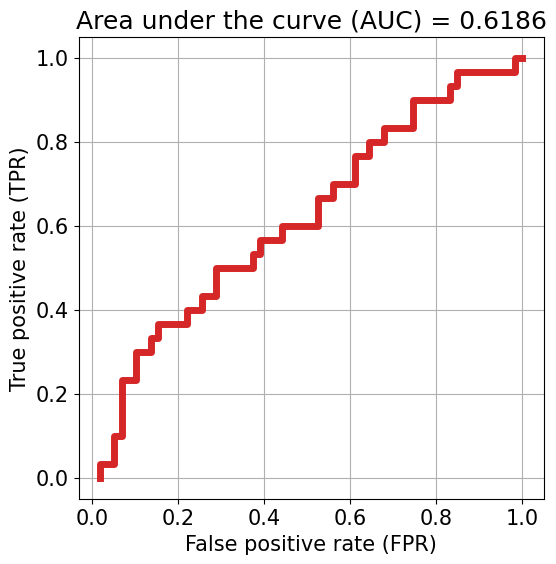

In [236]:
visual = Visualization()

visual.testROC(y_test,svdd.distance)

In [111]:
linear = {"type": 'linear', "offset": 0}
positive_penalty_ = 0.9
negetive_penalty_ = 0.9

# construct an SVDD model
svdd = SVDD(positive_penalty = positive_penalty_ , negetive_penalty = negetive_penalty_ ,kernel = linear)

# train SVDD model
svdd.fit(X_train, y_train)

# test SVDD model
accuracy = svdd.predict(X_test, y_test)
svdd.print_model()



--------- SVDD model results ---------

Kernel function              linear
Raduis                       685.431
Iteration                    15
Number of Support vectors    3
Rate  of  Support vectors    1.132 %
accuracy                     46.067%



In [117]:
poly = {"type": 'poly', "degree": 2, "offset": 0}
positive_penalty_ = 0.9
negetive_penalty_ = 0.9

# construct an SVDD model
svdd = SVDD(positive_penalty = positive_penalty_ , negetive_penalty = negetive_penalty_ ,kernel = poly)

# train SVDD model
svdd.fit(X_train, y_train)

# test SVDD model
accuracy = svdd.predict(X_test, y_test)
svdd.print_model()



--------- SVDD model results ---------

Kernel function              poly
Raduis                       240584.089
Iteration                    21
Number of Support vectors    2
Rate  of  Support vectors    0.755 %
accuracy                     52.809%



In [125]:
sigmoid = {"type": 'tanh', "gamma": 1e-10, "offset": 0.1}
positive_penalty_ = 0.9
negetive_penalty_ = 0.9

# construct an SVDD model
svdd = SVDD(positive_penalty = positive_penalty_ , negetive_penalty = negetive_penalty_ ,kernel = sigmoid)

# train SVDD model
svdd.fit(X_train, y_train)

# test SVDD model
accuracy = svdd.predict(X_test, y_test)
svdd.print_model()



--------- SVDD model results ---------

Kernel function              tanh
Raduis                       0.004
Iteration                    12
Number of Support vectors    50
Rate  of  Support vectors    18.868 %
accuracy                     51.685%



In [157]:
lapl = {"type": 'lapl', "sigma": 1}
positive_penalty_ = 0.9
negetive_penalty_ = 0.9

# construct an SVDD model
svdd = SVDD(positive_penalty = positive_penalty_ , negetive_penalty = negetive_penalty_ ,kernel = lapl)

# train SVDD model
svdd.fit(X_train, y_train)

# test SVDD model
accuracy = svdd.predict(X_test, y_test)
svdd.print_model()



--------- SVDD model results ---------

Kernel function              lapl
Raduis                       0.9948265307
Iteration                    6
Number of Support vectors    97
Rate  of  Support vectors    36.604 %
accuracy                     66.292%



# <h1><b>iris dataset from sklearn</b></h1>

In [166]:
X_train, X_test, y_train, y_test = Load_iris()

In [180]:
gauss = {"type": 'gauss', "sigma": 1}
positive_penalty_ = 0.9
negetive_penalty_ = 0.9

# construct an SVDD model
svdd = SVDD(positive_penalty = positive_penalty_ , negetive_penalty= negetive_penalty_ ,kernel = gauss)

# train SVDD model
svdd.fit(X_train, y_train)

# test SVDD model
accuracy = svdd.predict(X_test, y_test)
svdd.print_model()



--------- SVDD model results ---------

Kernel function              gauss
Raduis                       0.8879632592
Iteration                    9
Number of Support vectors    13
Rate  of  Support vectors    28.889 %
accuracy                     97.143%



We are here


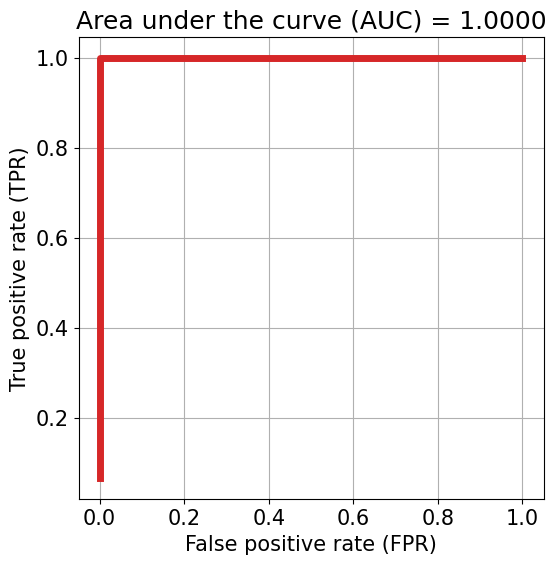

In [181]:
visual = Visualization()

visual.testROC(y_test,svdd.distance)

In [138]:
linear = {"type": 'linear', "offset": 0}
positive_penalty_ = 0.9
negetive_penalty_ = 0.9

# construct an SVDD model
svdd = SVDD(positive_penalty = positive_penalty_ , negetive_penalty = negetive_penalty_ ,kernel = linear)

# train SVDD model
svdd.fit(X_train, y_train)

# test SVDD model
accuracy = svdd.predict(X_test, y_test)
svdd.print_model()



--------- SVDD model results ---------

Kernel function              linear
Raduis                       2.526
Iteration                    7
Number of Support vectors    2
Rate  of  Support vectors    4.444 %
accuracy                     90.476%



In [139]:
poly = {"type": 'poly', "degree": 2, "offset": 0}
positive_penalty_ = 0.9
negetive_penalty_ = 0.9

# construct an SVDD model
svdd = SVDD(positive_penalty = positive_penalty_ , negetive_penalty = negetive_penalty_ ,kernel = poly)

# train SVDD model
svdd.fit(X_train, y_train)

# test SVDD model
accuracy = svdd.predict(X_test, y_test)
svdd.print_model()



--------- SVDD model results ---------

Kernel function              poly
Raduis                       2.030
Iteration                    7
Number of Support vectors    4
Rate  of  Support vectors    8.889 %
accuracy                     20.000%



In [142]:
sigmoid = {"type": 'tanh', "gamma": 1e-10, "offset": 0.1}
positive_penalty_ = 0.9
negetive_penalty_ = 0.9

# construct an SVDD model
svdd = SVDD(positive_penalty = positive_penalty_ , negetive_penalty = negetive_penalty_ ,kernel = sigmoid)

# train SVDD model
svdd.fit(X_train, y_train)

# test SVDD model
accuracy = svdd.predict(X_test, y_test)
svdd.print_model()



--------- SVDD model results ---------

Kernel function              tanh
Raduis                       0.0000135118
Iteration                    5
Number of Support vectors    45
Rate  of  Support vectors    100.000 %
accuracy                     96.190%



In [146]:
lapl = {"type": 'lapl', "sigma": 1}
positive_penalty_ = 0.9
negetive_penalty_ = 0.9

# construct an SVDD model
svdd = SVDD(positive_penalty = positive_penalty_ , negetive_penalty = negetive_penalty_ ,kernel = lapl)

# train SVDD model
svdd.fit(X_train, y_train)

# test SVDD model
accuracy = svdd.predict(X_test, y_test)
svdd.print_model()



--------- SVDD model results ---------

Kernel function              lapl
Raduis                       0.9055854192
Iteration                    9
Number of Support vectors    24
Rate  of  Support vectors    53.333 %
accuracy                     95.238%

